# Cell Cell Communication inference

## Introduction

Cells are not independent entities in biology, they react to stimuli coming
from their environment. Cells can react to chemical cues, but also to other
cells. These cell-cell signaling events can trigger crucial biological processes
like apoptosis or cell migration, making the study of them relevant to better
understand diseases. Cell-cell communication (CCC) events can be inferred from
trascriptomics using a prior knowledge resource and a statistical method. 

The goals of this tutorial are to:

- Introduce the CCC concept
- Learn how to run CCC methods
- Interpret the obtained scores

To do so, we will analyse a downsampled single-cell transcriptomics dataset
consisting of human immune cells from healthy and COVID-19 infected patients.
We leverage the tool [LIANA](https://saezlab.github.io/liana/), a collection of
CCC inference methods that can query prior knowledge to generate hypothesis
of cell interactions.

## Dependencies
To be able to run the code, we first need to load
the required packages.

In [1]:
# Single-cell processing
import scanpy as sc
import muon as mu

# CCC analysis
import liana as li

# Enrichment analysis
import decoupler as dc

# Data handling
import pandas as pd
import numpy as np
import plotnine as p9

# Plotting options, change to your liking
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))

## Data loading
Today we will look at ~25k PBMCs from 8 pooled patient lupus samples, each before and after IFN-beta stimulation

/home/badi/miniconda3/envs/comm/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
/home/badi/miniconda3/envs/comm/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


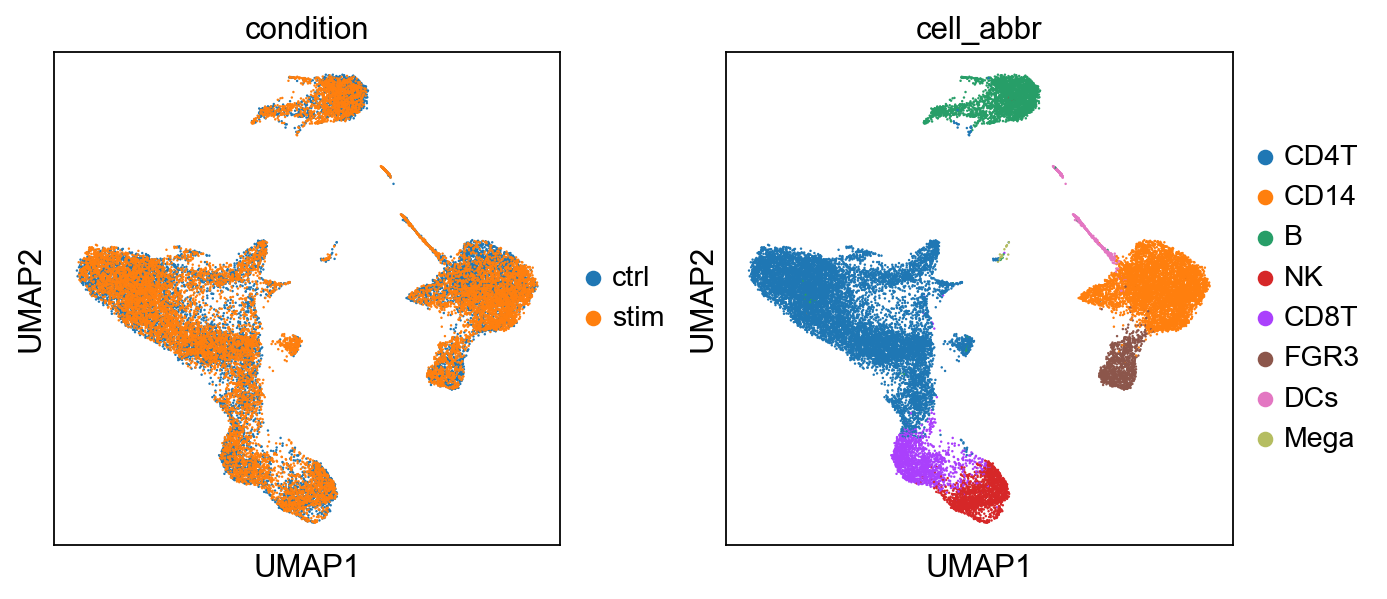

AnnData object with n_obs × n_vars = 24562 × 15701
    obs: 'nCount_RNA', 'nFeature_RNA', 'tsne1', 'tsne2', 'condition', 'cluster', 'cell_type', 'patient', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.4', 'seurat_clusters', 'sample', 'cell_abbr', 'n_genes'
    var: 'name', 'n_cells'
    uns: 'log1p', 'condition_colors', 'cell_abbr_colors'
    obsm: 'X_pca', 'X_umap'
    layers: 'counts'

In [2]:
adata = li.testing.datasets.kang_2018()
# filter cells and genes
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
# log1p normalize the data
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

sc.pl.umap(adata, color=['condition', 'cell_abbr'])
adata

## Inference of CCC events at the cluster level

Recently, multiple tools and resources that infer CCC were published with
different modeling strategies. All of them assume that CCC events can be inferred
only from transcriptomics. They check the expression of ligands coming from a
"source" cell type and a receptor from a "target" cell type that are known to 
interact. If both protein genes are expressed, the methods return
these interactions as being relevant for the given dataset. 

Discuss what are the limitations of assuming that CCC events can be inferred from
only transcriptomics. Think about how interactions between cells can occur.

Moreover, multiple prior knowledge resources of CCC interaction are available 
coming from different studies. You can print them with this line:

In [3]:
li.mt.show_methods()

,Method Name,Magnitude Score,Specificity Score,Reference
0,CellPhoneDB,lr_means,cellphone_pvals,"Efremova, M., Vento-Tormo, M., Teichmann, S.A...."
0,Connectome,expr_prod,scaled_weight,"Raredon, M.S.B., Yang, J., Garritano, J., Wang..."
0,log2FC,None,lr_logfc,"Dimitrov, D., Türei, D., Garrido-Rodriguez, M...."
0,NATMI,expr_prod,spec_weight,"Hou, R., Denisenko, E., Ong, H.T., Ramilowski,..."
0,SingleCellSignalR,lrscore,None,"Cabello-Aguilar, S., Alame, M., Kon-Sun-Tack, ..."
0,CellChat,lr_probs,cellchat_pvals,"Jin, S., Guerrero-Juarez, C.F., Zhang, L., Cha..."
0,Rank_Aggregate,magnitude_rank,specificity_rank,"Dimitrov, D., Türei, D., Garrido-Rodriguez, M...."
0,Geometric Mean,lr_gmeans,gmean_pvals,CellPhoneDBv2's permutation approach applied t...


Despite this, most published methods use a fixed resource and ignore the rest.

Discuss what happens if only one resource and method are taken into
consideration while ignoring the others.

To start, we will infer CCC interactions using the `natmi` method with the
`consensus` OmniPath resource. `natmi` ranks CCC events by computing the product between genes.

We will leverage the easy to use wrapper provided by `liana`:

In [4]:
li.mt.natmi(
    adata,
    groupby='cell_abbr',
    resource_name='consensus', # consensus is omnipath
    expr_prop = 0.1,
    use_raw=False,
    verbose=True
)

Using `.X`!
Converting mat to CSR format
0.45 of entities in the resource are missing from the data.
Generating ligand-receptor stats for 24562 samples and 15701 features


In [5]:
res_natmi_omnipath = (
    adata.uns['liana_res']
    .copy()
    .sort_values(li.mt.natmi.magnitude, ascending=li.mt.natmi.magnitude_ascending)
    .reset_index()
    [['ligand_complex', 'receptor_complex', 'source', 'target', li.mt.natmi.magnitude, li.mt.natmi.specificity]]
)
res_natmi_omnipath.head(10)

,ligand_complex,receptor_complex,source,target,expr_prod,spec_weight
0,TIMP1,CD63,FGR3,CD14,4.122536,0.115681
1,TIMP1,CD63,CD14,CD14,3.778349,0.106023
2,B2M,CD3D,CD8T,CD8T,3.352136,0.064528
3,B2M,CD3D,NK,CD8T,3.309923,0.063715
4,B2M,CD3D,FGR3,CD8T,3.036295,0.058448
5,B2M,CD3D,B,CD8T,3.003674,0.057820
6,B2M,CD3D,DCs,CD8T,2.967178,0.057117
7,TIMP1,CD63,FGR3,DCs,2.955963,0.082946
8,B2M,CD3D,CD4T,CD8T,2.942186,0.056636
9,B2M,CD3D,CD14,CD8T,2.852550,0.054911


Explore a little bit the obtained results, do they make biological sense? Search
for literature.

Now we will run it again, but this time changing the resource to 
connectomeDB2020 (the resource they used in `natmi`'s original publication):

In [6]:
li.mt.natmi(
    adata,
    groupby='cell_abbr',
    resource_name='connectomedb2020',
    expr_prop = 0.1,
    use_raw=False,
    verbose=True
)

Using `.X`!
Converting mat to CSR format
0.44 of entities in the resource are missing from the data.
Generating ligand-receptor stats for 24562 samples and 15701 features


In [7]:
res_natmi_connectomedb2020 = (
    adata.uns['liana_res']
    .copy()
    .sort_values(li.mt.natmi.magnitude, ascending=li.mt.natmi.magnitude_ascending)
    .reset_index()
    [['ligand_complex', 'receptor_complex', 'source', 'target', li.mt.natmi.magnitude, li.mt.natmi.specificity]]
)
res_natmi_connectomedb2020.head(10)

,ligand_complex,receptor_complex,source,target,expr_prod,spec_weight
0,TIMP1,CD63,FGR3,CD14,4.122536,0.115681
1,TIMP1,CD63,CD14,CD14,3.778349,0.106023
2,TIMP1,CD63,FGR3,DCs,2.955963,0.082946
3,TIMP1,CD63,DCs,CD14,2.800607,0.078587
4,TIMP1,CD63,CD14,DCs,2.709172,0.076021
5,TIMP1,CD63,FGR3,FGR3,2.091446,0.058687
6,TIMP1,CD63,DCs,DCs,2.008106,0.056349
7,TIMP1,CD63,CD14,FGR3,1.916833,0.053788
8,HLA-B,KLRD1,NK,NK,1.530458,0.090800
9,TIMP1,CD63,FGR3,NK,1.503832,0.042199


Compare the results, are they the same? What is the number of shared interactions between the top 100 of both runs?

In [8]:
# Explore
res_top_natmi = pd.merge(
    res_natmi_omnipath.head(100),
    res_natmi_connectomedb2020.head(100),
    on=['ligand_complex', 'receptor_complex', 'source', 'target'],
    how='inner',
    suffixes=['_natmi_omnipath', '_natmi_connectomedb2020']
)
res_top_natmi

,ligand_complex,receptor_complex,source,target,expr_prod_natmi_omnipath,spec_weight_natmi_omnipath,expr_prod_natmi_connectomedb2020,spec_weight_natmi_connectomedb2020
0,TIMP1,CD63,FGR3,CD14,4.122536,0.115681,4.122536,0.115681
1,TIMP1,CD63,CD14,CD14,3.778349,0.106023,3.778349,0.106023
2,TIMP1,CD63,FGR3,DCs,2.955963,0.082946,2.955963,0.082946
3,TIMP1,CD63,DCs,CD14,2.800607,0.078587,2.800607,0.078587
4,TIMP1,CD63,CD14,DCs,2.709172,0.076021,2.709172,0.076021
5,TIMP1,CD63,FGR3,FGR3,2.091446,0.058687,2.091446,0.058687
6,TIMP1,CD63,DCs,DCs,2.008106,0.056349,2.008106,0.056349
7,TIMP1,CD63,CD14,FGR3,1.916833,0.053788,1.916833,0.053788
8,HLA-B,KLRD1,NK,NK,1.530458,0.090800,1.530458,0.090800
9,TIMP1,CD63,FGR3,NK,1.503832,0.042199,1.503832,0.042199


Now let's try what happens when we change the method. The method `CellChat` first
transforms gene expresion into quantiles, computes the product between genes and finally
scales the obtained score between 0 and 1. To run the method let's use `liana` again:

In [9]:
li.mt.cellchat(
    adata,
    groupby='cell_abbr',
    resource_name='consensus',
    expr_prop = 0.1,
    use_raw=False,
    verbose=True,
    n_perms=1
)

Using `.X`!
Converting mat to CSR format
0.45 of entities in the resource are missing from the data.
Generating ligand-receptor stats for 24562 samples and 15701 features


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.40it/s]


In [10]:
res_cellchat_omnipath = (
    adata.uns['liana_res']
    .copy()
    .sort_values(li.mt.cellchat.magnitude, ascending=li.mt.cellchat.magnitude_ascending)
    .reset_index()
    [['ligand_complex', 'receptor_complex', 'source', 'target', li.mt.cellchat.magnitude, li.mt.cellchat.specificity]]
)
res_cellchat_omnipath.head(10)

,ligand_complex,receptor_complex,source,target,lr_probs,cellchat_pvals
0,TIMP1,CD63,FGR3,CD14,0.165383,0.0
1,TIMP1,CD63,CD14,CD14,0.154996,0.0
2,B2M,CD3D,CD8T,CD8T,0.128356,0.0
3,B2M,CD3D,NK,CD8T,0.126825,0.0
4,TIMP1,CD63,FGR3,DCs,0.126552,0.0
5,TIMP1,CD63,DCs,CD14,0.121107,0.0
6,TIMP1,CD63,CD14,DCs,0.118258,0.0
7,B2M,CD3D,FGR3,CD8T,0.117747,0.0
8,B2M,CD3D,B,CD8T,0.116740,0.0
9,B2M,CD3D,DCs,CD8T,0.115565,0.0


Like before, compare the top 100 interactions but now across the three different
results.

In [11]:
# Explore
pd.merge(
    res_top_natmi,
    res_cellchat_omnipath.head(100),
    on=['ligand_complex', 'receptor_complex', 'source', 'target'],
    how='inner',
)

,ligand_complex,receptor_complex,source,target,expr_prod_natmi_omnipath,spec_weight_natmi_omnipath,expr_prod_natmi_connectomedb2020,spec_weight_natmi_connectomedb2020,lr_probs,cellchat_pvals
0,TIMP1,CD63,FGR3,CD14,4.122536,0.115681,4.122536,0.115681,0.165383,0.0
1,TIMP1,CD63,CD14,CD14,3.778349,0.106023,3.778349,0.106023,0.154996,0.0
2,TIMP1,CD63,FGR3,DCs,2.955963,0.082946,2.955963,0.082946,0.126552,0.0
3,TIMP1,CD63,DCs,CD14,2.800607,0.078587,2.800607,0.078587,0.121107,0.0
4,TIMP1,CD63,CD14,DCs,2.709172,0.076021,2.709172,0.076021,0.118258,0.0
5,TIMP1,CD63,FGR3,FGR3,2.091446,0.058687,2.091446,0.058687,0.089425,0.0
6,TIMP1,CD63,DCs,DCs,2.008106,0.056349,2.008106,0.056349,0.091531,0.0
7,TIMP1,CD63,CD14,FGR3,1.916833,0.053788,1.916833,0.053788,0.083332,0.0
8,TIMP1,CD63,FGR3,NK,1.503832,0.042199,1.503832,0.042199,0.066074,0.0
9,TIMP1,CD63,DCs,FGR3,1.420805,0.039869,1.420805,0.039869,0.063927,0.0


What do you think of the overlap, are they comparable?

As you have seen, results tend to be quite different depending on the choice of
method and prior knowledge database. To try to mitigate this, `liana` uses
a consensus database as the prior knowledge resource (where interactions coming
from different resources where aggregated). It also runs several top-performing
CCC inference methods sequentially. We can run it with:

In [12]:
# Run rank_aggregate
li.mt.rank_aggregate(
    adata,
    groupby='cell_abbr',
    resource_name='consensus',
    expr_prop = 0.1,
    use_raw=False,
    n_perms=1,
    verbose=True
)

Using `.X`!
Converting mat to CSR format
0.45 of entities in the resource are missing from the data.
Generating ligand-receptor stats for 24562 samples and 15701 features
Assuming that counts were `natural` log-normalized!
Running CellPhoneDB


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 88.79it/s]


Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR
Running CellChat


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.58it/s]


In [13]:
adata.uns['liana_res']

,source,target,ligand_complex,receptor_complex,lr_means,cellphone_pvals,expr_prod,scaled_weight,lr_logfc,spec_weight,lrscore,lr_probs,cellchat_pvals,steady_rank,specificity_rank,magnitude_rank
1083,CD8T,CD8T,B2M,CD3D,2.523310,0.0,3.352136,1.024501,0.740905,0.064528,0.983202,0.128356,0.0,0.021435,0.045685,1.205580e-07
1048,NK,CD8T,B2M,CD3D,2.496489,0.0,3.309923,0.959119,0.696277,0.063715,0.983097,0.126825,0.0,0.021435,0.045685,2.856267e-07
1122,FGR3,CD8T,B2M,CD3D,2.322635,0.0,3.036295,0.535343,0.406047,0.058448,0.982365,0.117747,0.0,0.021435,0.045685,2.280523e-06
1010,B,CD8T,B2M,CD3D,2.301909,0.0,3.003674,0.484818,0.409231,0.057820,0.982271,0.116740,0.0,0.021435,0.045685,3.245474e-06
1173,DCs,CD8T,B2M,CD3D,2.278720,0.0,2.967178,0.428295,0.370620,0.057117,0.982164,0.115565,0.0,0.021435,0.045685,4.449761e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494,DCs,CD14,S100A9,CD36,0.097569,1.0,0.009407,0.170615,-0.078668,0.037032,0.756127,0.000000,1.0,1.000000,1.000000,1.000000e+00
495,DCs,CD14,CD47,SIRPA,0.225344,0.0,0.023188,0.438669,0.152924,0.083291,0.829583,0.000000,1.0,1.000000,0.401489,1.000000e+00
496,DCs,CD14,HLA-C,LILRA3,0.779995,1.0,0.156166,0.120694,-0.088500,0.037972,0.926649,0.000000,1.0,1.000000,1.000000,1.000000e+00
1326,CD14,FGR3,HMGB1,TLR2,0.167092,1.0,0.024761,0.074536,-0.205636,0.027636,0.834174,0.000294,0.0,1.000000,1.000000,1.000000e+00


We can then visualize the top interactions by running

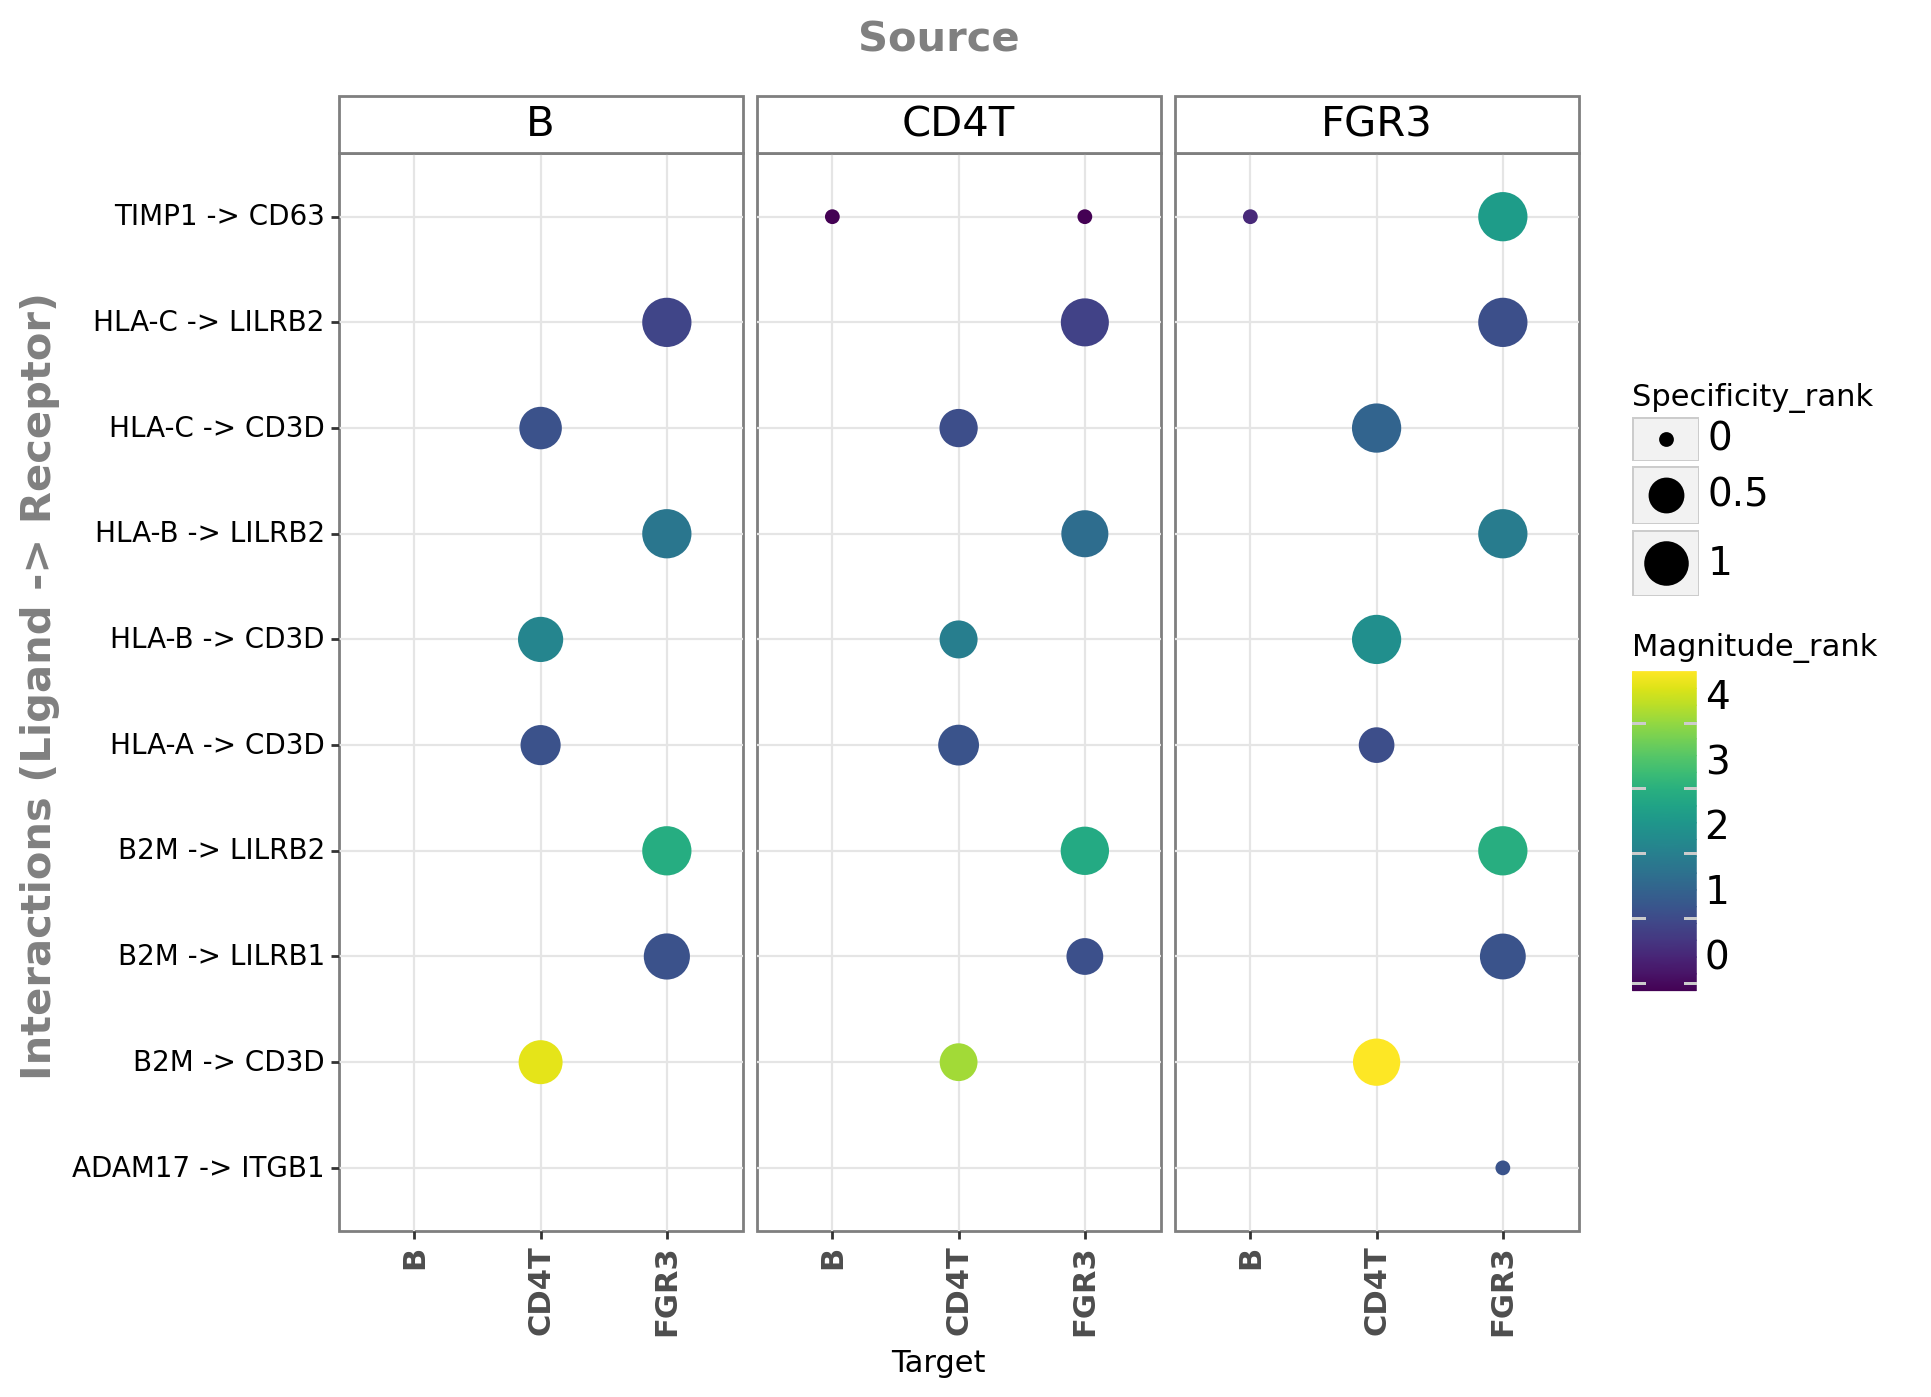

<ggplot: (8756833877686)>

In [14]:
li.pl.dotplot(adata = adata,
              colour='magnitude_rank',
              size='specificity_rank',
              inverse_size=True,
              inverse_colour=True, # we inverse sign since we want small p-values to have large sizes
              source_labels=["CD4T", "B", "FGR3"],
              target_labels=["CD4T", "B", "FGR3"],
              top_n=10,
              orderby='magnitude_rank',
              orderby_ascending=True,
              figure_size=(8, 7)
             )

Discuss a little bit the results, do these interactions make sense? You can look online

## Inference of CCC events in disease

Up until now we were ignoring the disease vs healthy comparison in the inference
of CCC events. In disease, we expect to see differences in how cell interact, for
example we might see T cells interacting with infected cells to trigger their
apoptosis but not so much in healthy tissue, or cancer cells interacting with
many cell types to create a tumor microenviroment. 

To compare healthy vs disease, we will compute their CCC events per sample:

In [15]:
li.mt.rank_aggregate.by_sample(
    adata,
    groupby='cell_abbr',
    sample_key='sample', # sample key by which we which to loop
    use_raw=False,
    expr_prop = 0.1,
    n_perms=1, # reduce permutations for speed
    return_all_lrs=False, # we don't return all LR values to utilize MOFA's flexible views
    verbose=True, # use 'full' to show all information
)

Now running: stim&1488: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [01:19<00:00,  4.98s/it]


Here are the results:

In [16]:
adata.uns["liana_res"].sort_values("magnitude_rank").head()

,sample,source,target,ligand_complex,receptor_complex,lr_means,cellphone_pvals,expr_prod,scaled_weight,lr_logfc,spec_weight,lrscore,lr_probs,cellchat_pvals,steady_rank,specificity_rank,magnitude_rank
18040,stim&1015,NK,CD8T,B2M,CD3D,2.483041,0.0,2.652776,1.086438,0.628031,0.077230,0.978141,0.119143,0.0,0.016701,0.061037,4.430283e-09
6719,ctrl&1039,FGR3,CD14,TIMP1,CD63,2.547695,0.0,5.674415,1.301281,1.767435,0.104337,0.981838,0.246975,0.0,0.000272,0.043421,4.913099e-09
26009,stim&1256,NK,CD8T,B2M,CD3D,2.655090,0.0,3.819609,1.123354,0.749565,0.085849,0.981475,0.144068,0.0,0.018353,0.063544,6.091422e-09
1597,ctrl&107,FGR3,CD14,TIMP1,CD63,2.544711,0.0,5.852476,1.065290,1.678028,0.104096,0.982827,0.232994,0.0,0.001810,0.059312,8.509626e-09
9014,ctrl&1244,FGR3,CD14,TIMP1,CD63,2.504210,0.0,5.661785,1.703509,2.209408,0.116978,0.985015,0.222247,0.0,0.000029,0.001949,1.009959e-08


We can visualize them:

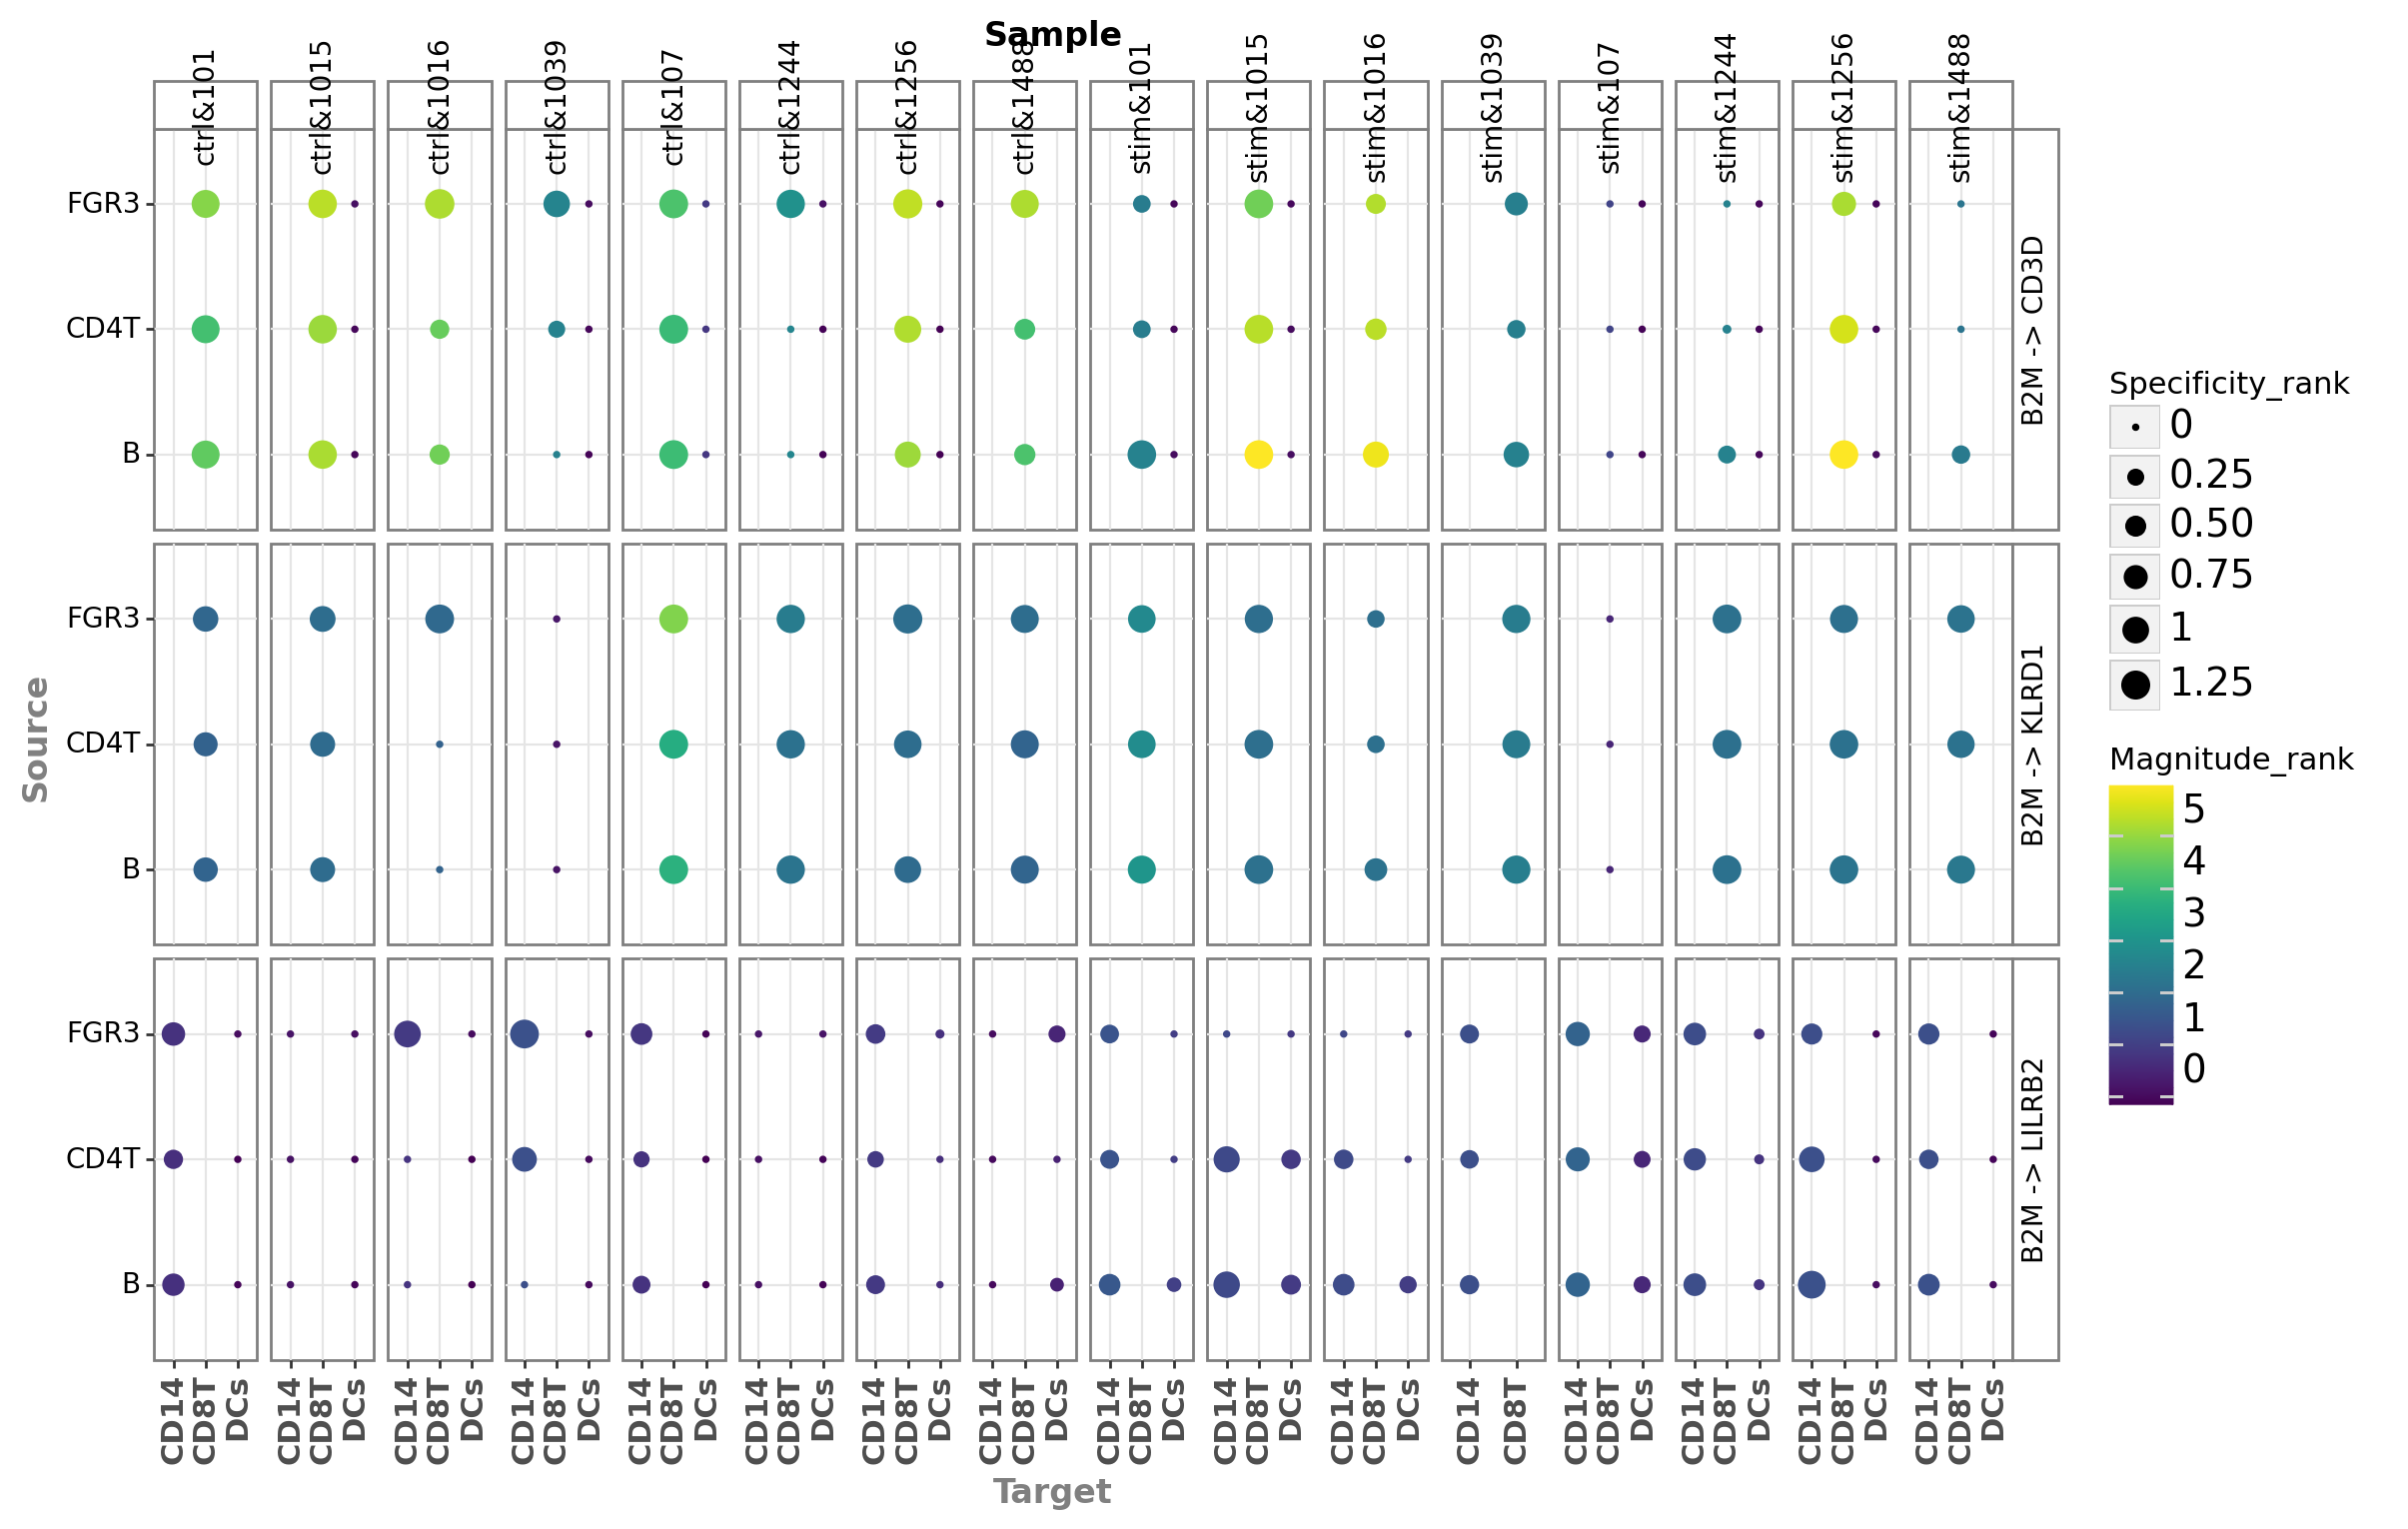

<ggplot: (8756847013420)>

In [17]:
(
    li.pl.dotplot_by_sample(adata, sample_key='sample',
                            colour="magnitude_rank", size="specificity_rank",
                            source_labels=["CD4T", "B", "FGR3"],
                            target_labels=["CD8T", 'DCs', 'CD14'],
                            ligand_complex=["B2M"],
                            inverse_colour=True,
                            inverse_size=True,
                            receptor_complex=["KLRD1", "LILRB2", "CD3D"],
                            figure_size=(12, 8),
                            size_range=(0.5, 5),
                           ) +
    # rotate facet labels
    p9.theme(strip_text=p9.element_text(size=10, colour="black", angle=90))
 )

Even on a small subset interactions and cell types, we can see that interpretation becomes challenging. To overcome this, we can use MOFA to find the variable CCC patterns across contexts/samples.

Before we can identify the variable CCC patterns across contexts/samples, we need to create a multi-view structure. In this case, we will use the `lrs_to_views` function from liana to create a list of views (stored in a MuData object), where each view corresponds to a pair of potentially interacting cell types. The scores of interactions between cell type pairs represent those inferred with liana, stored by default in `adata.uns['liana_res']`. Here, we will use liana’s aggregate `magnitude_rank`.

In [18]:
mdata = li.multi.lrs_to_views(
    adata,
    score_key='magnitude_rank',
    sample_key='sample',
    obs_keys=['patient', 'condition'], # add those to mdata.obs
    lr_prop = 0.3, # minimum required proportion of samples to keep an LR
    lrs_per_sample = 20, # minimum number of interactions to keep a sample in a specific view
    lrs_per_view = 20, # minimum number of interactions to keep a view
    samples_per_view = 10, # minimum number of samples to keep a view
    min_variance = 0, # minimum variance to keep an interaction
    lr_fill = 0, # fill missing LR values across samples with this
    verbose=True
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:00<00:00, 196.24it/s]


In [19]:
mu.tl.mofa(mdata,
           use_obs='union',
           convergence_mode='medium',
           outfile='models/mofatalk.h5ad',
           n_factors=4,
           )


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        
Loaded view='FGR3&CD14' group='group1' with N=16 samples and D=71 features...
Loaded view='FGR3&DCs' group='group1' with N=16 samples and D=85 features...
Loaded view='CD14&CD14' group='group1' with N=16 samples and D=69 features...
Loaded view='NK&CD8T' group='group1' with N=16 samples and D=33 features...
Loaded view='CD8T&CD8T' group='group1' with N=16 samples and D=37 featur

In [20]:
# obtain factor scores
factor_scores = li.multi.get_factor_scores(mdata, obsm_key='X_mofa')
factor_scores.head()

,sample,Factor_1,Factor_2,Factor_3,Factor_4,patient,condition
0,ctrl&101,-0.351780,-0.022480,-0.010205,-0.009889,patient_101,ctrl
1,ctrl&1015,-0.343454,-0.023541,-0.012797,-0.010698,patient_1015,ctrl
2,ctrl&1016,-0.344838,-0.022999,-0.011007,-0.010218,patient_1016,ctrl
3,ctrl&1039,-0.324951,-0.022055,0.195354,-0.010301,patient_1039,ctrl
4,ctrl&107,-0.337035,-0.018800,-0.013755,-0.009356,patient_107,ctrl


In [21]:
 # we use a paired t-test as the samples are paired
from scipy.stats import ttest_rel

# split in control and stimulated
group1 = factor_scores[factor_scores['condition']=='ctrl']
group2 = factor_scores[factor_scores['condition']=='stim']

# get all columns that contain factor & loop
factors = [col for col in factor_scores.columns if 'Factor' in col]
for factor in factors:
    print(ttest_rel(group1[factor], group2[factor]))

TtestResult(statistic=-116.2368396841578, pvalue=9.197478981442526e-13, df=7)
TtestResult(statistic=-0.9931290689214372, pvalue=0.3537285165322913, df=7)
TtestResult(statistic=1.0573084723625357, pvalue=0.3254877581600365, df=7)
TtestResult(statistic=-0.9988642303408987, pvalue=0.35112958341673045, df=7)


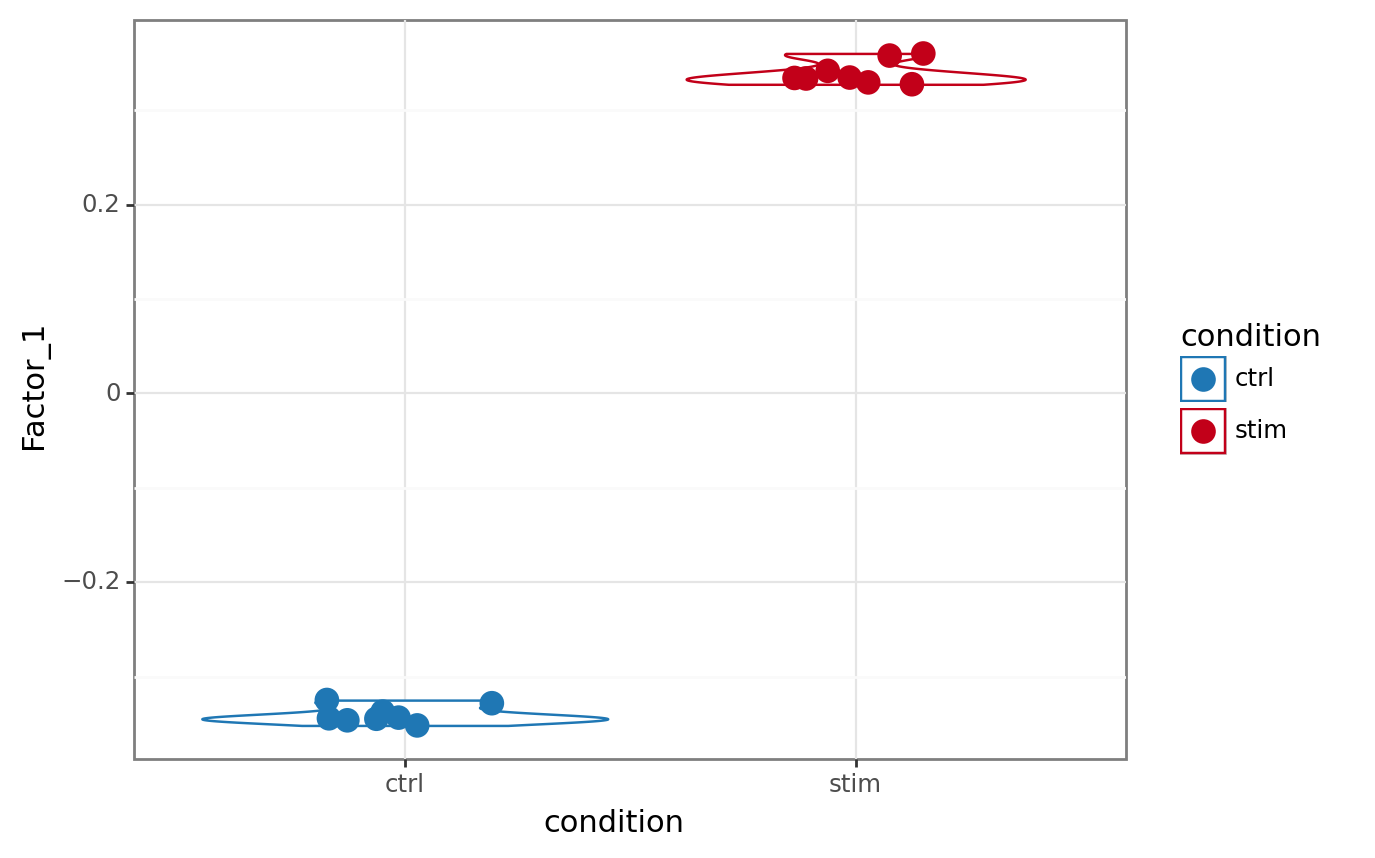

<ggplot: (8756833877164)>

In [22]:
# scatterplot
(
    p9.ggplot(factor_scores) +
    p9.aes(x='condition', colour='condition', y='Factor_1') +
    p9.geom_violin() +
    p9.geom_jitter(size=4, width=0.2) +
    p9.theme_bw() +
    p9.scale_colour_manual(values=['#1f77b4', '#c20019'])
)

Now that we have identified a factor that is associated with the sample condition, we can check the ligand-receptor loadings with the highest loadings:

In [23]:
factor1_loadings = li.multi.get_variable_loadings(
    mdata,
    0,
    view_separator=':',
    pair_separator="&",
    variable_separator="^"
) # get loadings for factor 1

factor1_loadings.head()

,loadings,ligand_complex,receptor_complex,source,target
478,1.457877,HLA-DRA,LAG3,DCs,CD8T
997,1.439645,TNFSF13B,HLA-DPB1,CD14,DCs
479,1.422595,HLA-DRB1,LAG3,DCs,CD8T
169,1.421602,CCL8,CCR1,CD14,CD14
475,1.386953,HLA-DPB1,LAG3,DCs,CD8T


We can visualize them

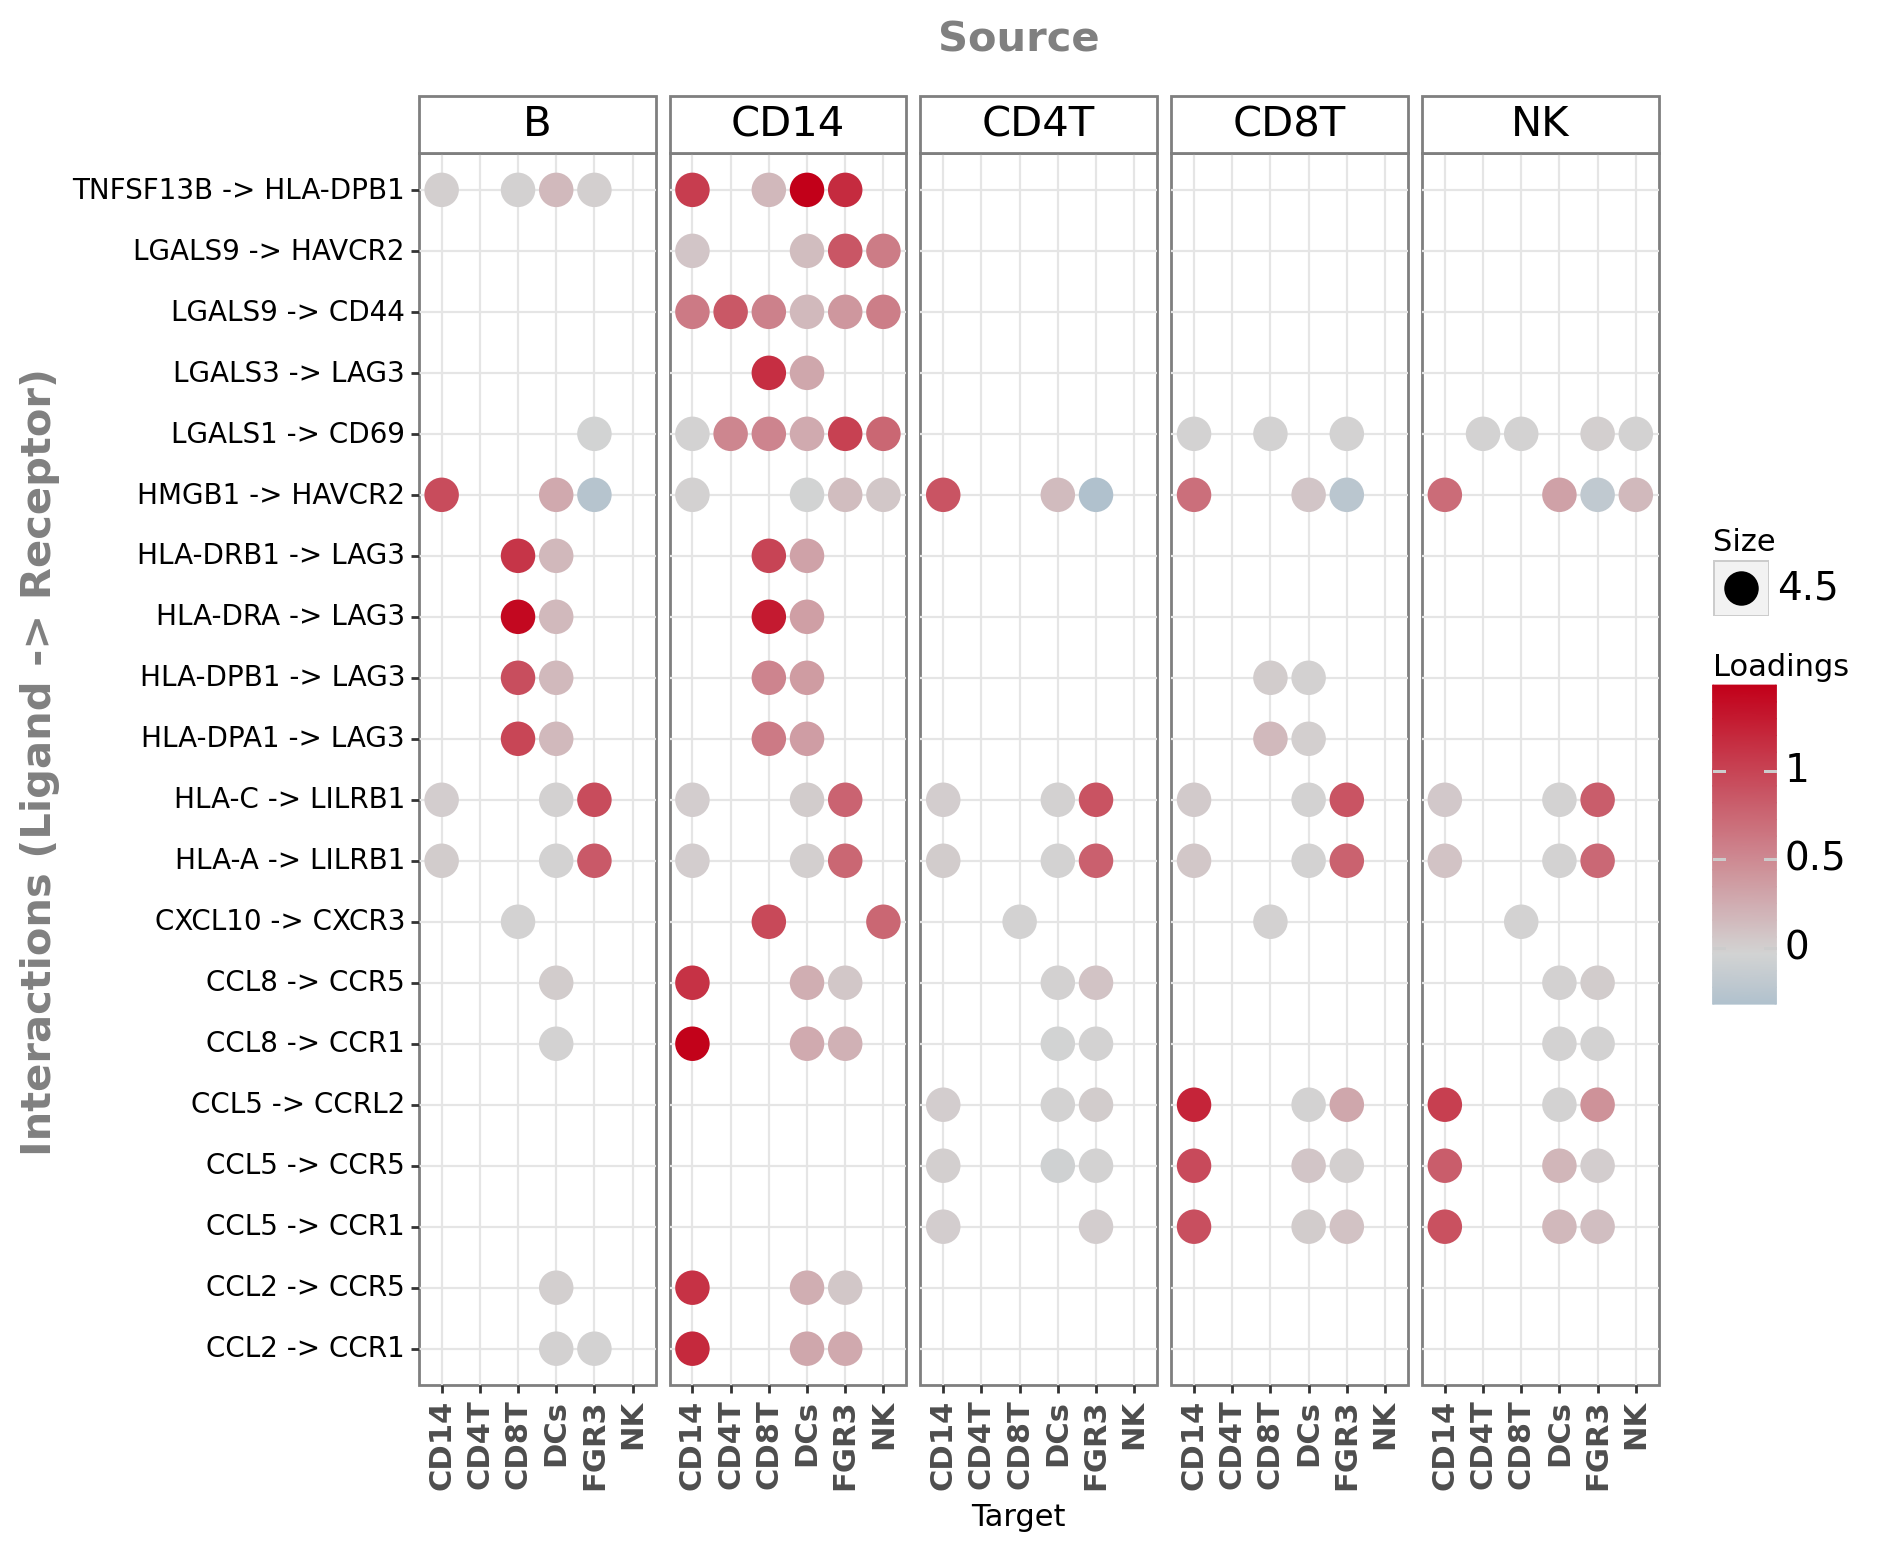

<ggplot: (8756847262390)>

In [24]:
# here we will just assign the size of the dots, but this can be replace by any other statistic
factor1_loadings['size'] = 4.5

my_plot = li.pl.dotplot(
    liana_res = factor1_loadings,
    size='size',
    colour='loadings',
    orderby='loadings',
    top_n=20,
    source_labels=['NK', 'B', 'CD4T', 'CD8T', 'CD14'],
    orderby_ascending=False,
    size_range=(0.1, 6),
    figure_size=(8, 8)
)

# change colour, with mid as white
my_plot + p9.scale_color_gradient2(low='#1f77b4', mid='lightgray', high='#c20019')

Here, we can see that certain interactions from Factor 1 have high positive loadings. These are interactions that are associated with the samples with high factor scores (i.e. the stimulated samples with high scores in Factor 1).

## Pathway enrichment

As we saw yesterday, we can run enrichment analysis to identify which pathways are upregulated or downregulated. 

In [25]:
# Load progeny
progeny = dc.get_progeny(top=5000)

# load full list of ligand-receptor pairs
lr_pairs = li.resource.select_resource('consensus')

In [26]:
# generate ligand-receptor geneset
lr_progeny = li.fun.generate_lr_geneset(lr_pairs, progeny, lr_separator="^")
lr_progeny.head(10)

,source,interaction,weight
1,JAK-STAT,LGALS9^PTPRC,1.307807
74,Androgen,SEMA4D^MET,-0.831693
90,Androgen,HGF^MET,-1.288956
106,Androgen,TIMP3^MET,-1.122612
151,NFkB,SELE^CD44,3.332552
158,TNFa,SELE^CD44,3.322682
184,EGFR,COL6A5^CD44,0.871610
259,NFkB,FN1^CD44,2.795337
272,TNFa,FN1^CD44,2.590177
363,WNT,COL6A1^CD44,-0.404814


In [27]:
lr_loadings =  li.multi.get_variable_loadings(mdata,
                                              0, # get loadings for factor 1
                                              view_separator=':',
                                              )
lr_loadings.set_index('variable', inplace=True)
# pivot views to wide
lr_loadings = lr_loadings.pivot(columns='view', values='loadings')
# replace NaN with 0
lr_loadings.replace(np.nan, 0, inplace=True)
lr_loadings.head()

view,B&CD14,B&CD4T,B&CD8T,B&DCs,B&FGR3,CD14&CD14,CD14&CD4T,CD14&CD8T,CD14&DCs,CD14&FGR3,...,FGR3&CD8T,FGR3&DCs,FGR3&FGR3,FGR3&NK,NK&CD14,NK&CD4T,NK&CD8T,NK&DCs,NK&FGR3,NK&NK
variable,,,,,,,,,,,,,,,,,,,,,
ADAM10^AXL,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.132484,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ADAM10^CD44,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.008149,0.010117,0.000081,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ADAM17^RHBDF2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.196303,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ADAM28^ITGA4,0.0,0.0,0.0,0.0,0.164309,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ADM^CALCRL,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,-0.275565,0.0,...,0.000000,-0.000047,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
# run pathway enrichment analysis
estimate, pvals =  dc.run_mlm(lr_loadings.T, lr_progeny,
                              source="source", target="interaction",
                              min_n=5)
# pivot columns to long
estimate = (estimate.
            melt(ignore_index=False, value_name='estimate', var_name='pathway').
            reset_index().
            rename(columns={'index':'view'})
            )

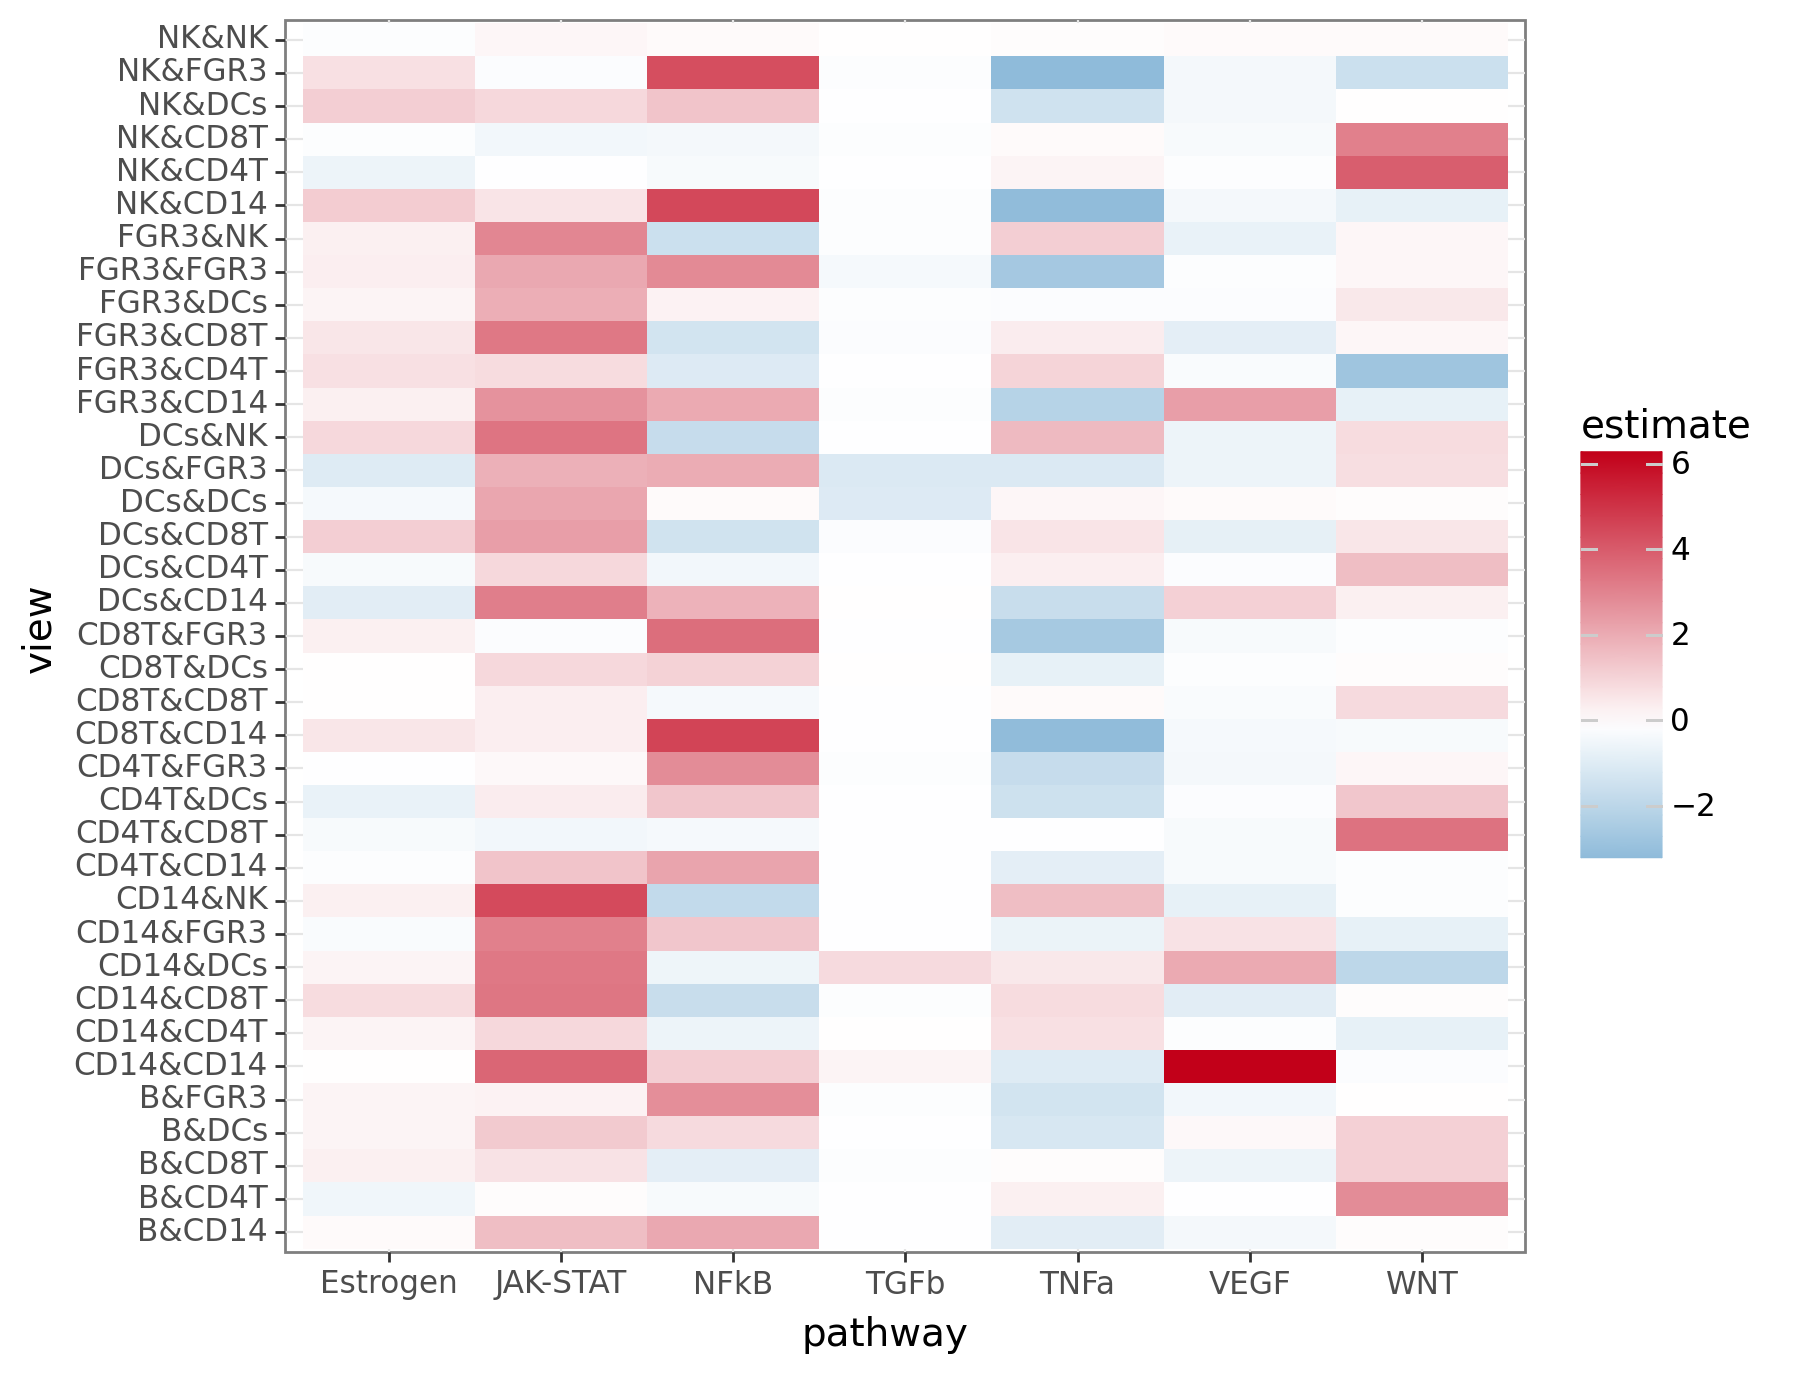

<ggplot: (8756847454623)>

In [29]:
## p9 tile plot
(p9.ggplot(estimate) +
 p9.aes(x='pathway', y='view') +
 p9.geom_tile(p9.aes(fill='estimate')) +
 p9.scale_fill_gradient2(low='#1f77b4', high='#c20019') +
 p9.theme_bw(base_size=14) +
 p9.theme(figure_size=(8, 8))
)

Here we can see that specific interactions are enriched by different pathways.